In [ ]:
deltat = 5
assets_tickers = ["XLY", "XLP", "XLE", "XLF", "XLV", "XLI", "XLB", "XLK", "XLU", "XLRE", "GLD", "IAU", "SGOL", "SLV", "SIVR", "PPLT", "PALL", "USO", "OIL", "UNG", "GAZ", "CPER", "JJC", "JJU", "CORN", "WEAT", "SOYB", "SGG", "JO", "PDBC", "GSG", "USCI", "DBC", "EUSA", "EWC", "EWU", "EWG", "EWQ", "EWJ", "MCHI", "INDA", "EWA", "EWZ", "EWY", "EWW", "EWL", "EWT", "EWH", "EWS", "EWI", "EWP", "EWN", "EWD", "EWO", "EWK", "EDEN", "EFNL", "EIS"]

# List of yearly `.tar` files to process
yearly_tar_files = [
    # "/Users/lucasalvador/Downloads/ETFs-2007.tar",
    # "/Users/lucasalvador/Downloads/ETFs-2008.tar",
    "/Users/lucasalvador/Downloads/ETFs-2009.tar",
    "/Users/lucasalvador/Downloads/ETFs-2010.tar",
    "/Users/lucasalvador/Downloads/ETFs-2011.tar",
    "/Users/lucasalvador/Downloads/ETFs-2012.tar",
]
average_diffs = {}

In [ ]:
import tarfile
from io import BytesIO
import polars as pl
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm

def set_timeseries(data):

    base_date = datetime(1899, 12, 30)

    data = data.with_columns(
        (base_date + pl.col("xltime").cast(float) * timedelta(days=1)).alias("datetime")
    )

    data = data.with_columns(pl.col("datetime").dt.convert_time_zone("America/New_York"))

    data = data.drop("xltime").sort("datetime")

    return data

# Define the expected schemas
schemas = {
    "bbo": {
        "xltime": pl.Float64,
        "bid-price": pl.Float64,
        "bid-volume": pl.Int32,
        "ask-price": pl.Float64,
        "ask-volume": pl.Int32,
    },
    "trade": {
        "xltime": pl.Float64,
        "trade-price": pl.Float64,
        "trade-volume": pl.Int32,
        "trade-stringflag": pl.Utf8,
        "trade-rawflag": pl.Utf8,
    },
}



# Dictionary to store concatenated DataFrames for each asset
assets_data = {}

def validate_and_fix_schema(df, expected_schema):
    for col, expected_type in expected_schema.items():
        if col not in df.columns:
            raise ValueError(f"Missing column: {col}")
        
        # If the column type does not match the expected type
        if df[col].dtype != expected_type:
            # Handle Float64 columns
            if expected_type == pl.Float64:
                df = df.with_columns(
                    # Ensure the column is cast to Utf8 for string operations
                    pl.when(pl.col(col).cast(pl.Utf8).str.strip_chars().is_in(["", "()", None]))
                    .then(None)
                    .otherwise(pl.col(col).cast(pl.Utf8))
                    .str.replace_all(r"[^\d.]", "")  # Remove non-numeric characters
                    .cast(pl.Float64)  # Cast back to Float64
                    .alias(col)
                )
            # Handle Int32 columns
            elif expected_type == pl.Int32:
                df = df.with_columns(
                    # Ensure the column is cast to Utf8 for string operations
                    pl.when(pl.col(col).cast(pl.Utf8).str.strip_chars().is_in(["", "()", None]))
                    .then(None)
                    .otherwise(pl.col(col).cast(pl.Utf8))
                    .str.replace_all(r"[^\d]", "")  # Remove non-numeric characters
                    .cast(pl.Int32)  # Cast back to Int32
                    .alias(col)
                )
            else:
                # Cast other types directly
                df = df.with_columns(df[col].cast(expected_type).alias(col))
    return df

for sector in tqdm(assets_tickers):
    del assets_data
    del schemas 
    schemas = {
        "bbo": {
            "xltime": pl.Float64,
            "bid-price": pl.Float64,
            "bid-volume": pl.Int32,
            "ask-price": pl.Float64,
            "ask-volume": pl.Int32,
        },
        "trade": {
            "xltime": pl.Float64,
            "trade-price": pl.Float64,
            "trade-volume": pl.Int32,
            "trade-stringflag": pl.Utf8,
            "trade-rawflag": pl.Utf8,
        },
    }

    assets_data = {}
    # Step 1: Iterate through yearly `.tar` files
    for yearly_tar_path in yearly_tar_files:
        print(f"Processing yearly tar: {yearly_tar_path}")
        
        with tarfile.open(yearly_tar_path, "r") as outer_tar:
            # Step 2: Iterate through files in the yearly `.tar`
            for member in outer_tar.getmembers():
                if member.isfile() and member.name.startswith(f"./{sector}") and member.name.endswith(".tar"):
                    print(f"Processing inner tar: {member.name}")
                    
                    # Determine file type ("bbo" or "trade") based on the name
                    if "bbo" in member.name:
                        file_type = "bbo"
                        expected_schema = schemas["bbo"]
                    elif "trade" in member.name:
                        continue
                        file_type = "trade"
                        expected_schema = schemas["trade"]
                    else:
                        print(f"Skipping unknown file type: {member.name}")
                        continue
                    
                    # Step 3: Extract the inner `.tar` file
                    inner_tar_data = BytesIO(outer_tar.extractfile(member).read())
                    with tarfile.open(fileobj=inner_tar_data, mode="r") as inner_tar:
                        parquet_files = []
                        
                        for inner_member in inner_tar.getmembers():
                            # Look for `.parquet` files
                            if inner_member.isfile() and inner_member.name.endswith(".parquet"):
                                parquet_data = BytesIO(inner_tar.extractfile(inner_member).read())
                                df = pl.read_parquet(parquet_data)
                                
                                # Validate and fix schema
                                try:
                                    df = validate_and_fix_schema(df, expected_schema)
                                    parquet_files.append(df)
                                except ValueError as e:
                                    print(f"Schema error in file {inner_member.name}: {e}")
                                    continue
                        
                        # Step 4: Concatenate all Parquet files for this asset in the year
                        if parquet_files:
                            combined_df = pl.concat(parquet_files, how="vertical")
                            
                            combined_df = set_timeseries(combined_df)
                            # Extract asset name (e.g., `EWW.P_bbo` from `EWW.P_bbo_2007.tar`)
                            asset_name = member.name.rsplit("_", 1)[0]
                            
                            # Append to the existing data for the same asset across years
                            if asset_name in assets_data:
                                assets_data[asset_name] = pl.concat([assets_data[asset_name], combined_df], how="vertical")
                            else:
                                assets_data[asset_name] = combined_df
                            print(f"Combined DataFrame for {asset_name} now has {len(assets_data[asset_name])} rows.")

    # Step 5: Process or save the final combined DataFrames
    for asset_name, df in assets_data.items():

        print(f"\nFinal DataFrame for {asset_name}:\n{df}")
        # Example: Save to disk if needed
        # df.write_parquet(f"Data/{asset_name}_combined.parquet")

    if assets_data:
        k = sector
        
        df = assets_data[f"./{k}.P_bbo"]

        df = df.with_columns(pl.col("datetime").diff().alias("time_diff"))

        # Calculate the average difference
        average_diff = df["time_diff"].drop_nulls().mean()

        print(f"Average time difference for {k}: {average_diff}")
        average_diffs[k] = average_diff
        del df

In [ ]:
import pandas as pd
all_tickers = assets_tickers

data = []
for ticker in all_tickers:
    if ticker in average_diffs:
        seconds_val = average_diffs[ticker].total_seconds()  
        data.append((ticker, seconds_val))

df = pd.DataFrame(data, columns=["Ticker", "Total_Seconds"])

df.to_csv("average_diffs_seconds.csv", index=False)

In [ ]:
import pandas as pd
average_diff_seconds = pd.read_csv("average_diffs_seconds.csv")

In [ ]:
average_diff_seconds_clean = average_diff_seconds[~((average_diff_seconds['Ticker'] == "EDEN")| (average_diff_seconds['Ticker'] == "INDA")| (average_diff_seconds['Ticker'] == "EFNL"))]

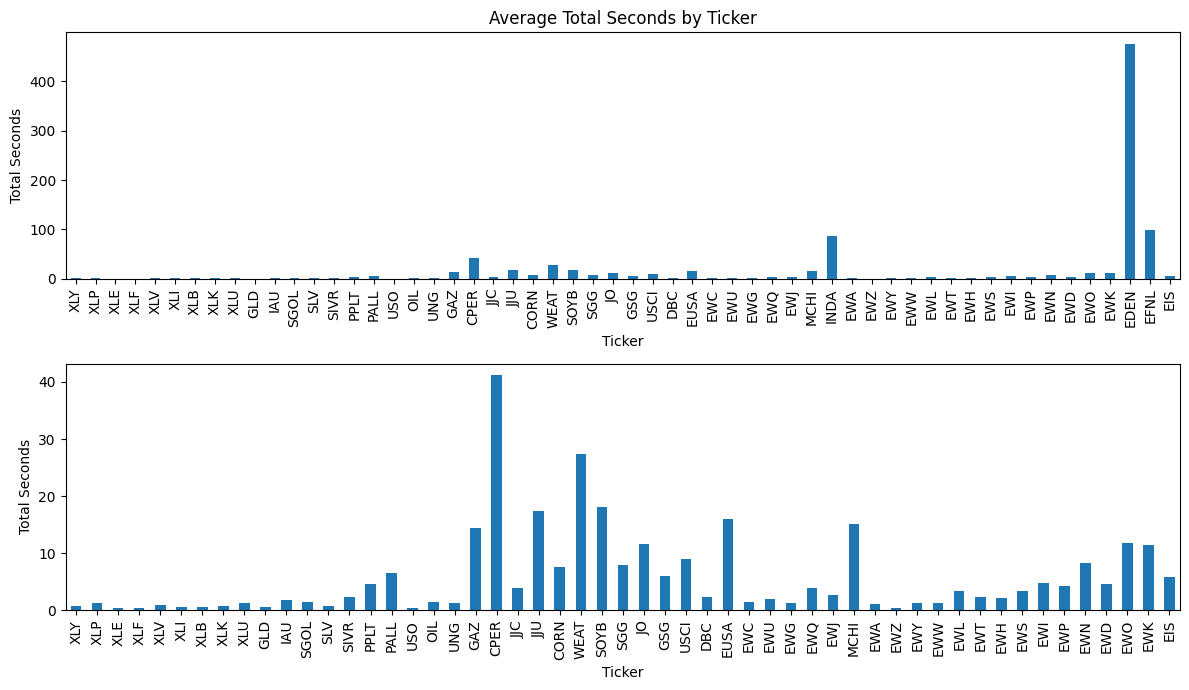

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(12, 7))

# First subplot: Average Total Seconds by Ticker
average_diff_seconds.plot(x='Ticker', y='Total_Seconds', kind='bar', ax=axs[0], legend=False)
axs[0].set_title('Average Total Seconds by Ticker')
axs[0].set_xlabel('Ticker')
axs[0].set_ylabel('Total Seconds')
axs[0].tick_params(axis='x', rotation=90)

# Second subplot: Price without outliers
average_diff_seconds_clean.plot(x='Ticker', y='Total_Seconds', kind='bar', ax=axs[1], legend=False)

axs[1].set_xlabel('Ticker')
axs[1].set_ylabel('Total Seconds')
axs[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()